# 10. Milestone Project 2: SkimLit 📄🔥

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!wget "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"

--2022-07-19 04:11:11--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-19 04:11:11 (105 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from helper_functions import create_tensorboard_callback, calculate_results, compare_historys, plot_loss_curves
import tensorflow as tf

%matplotlib inline
tf.__version__

'2.8.2'

## Machine Learning Engineer

1. Download a paper
2. Implement it
3. Keep doing this until you have skills

Raw Abstract Text -> Model (SkimLit) -> Model predicts topic of each sequence

## What we're going to cover

* Downloading a text dataset (PubMed 200K RCT)
* Writing a preprocessing function for our data
* Setting up multiple modelling experiments with different levels of embeddings
* Building a multimodal model to take in different sources of data
    * Replicating the model powering https://arxiv.org/abs/1710.06071
* Finding the most wrong prediction examples

What section should a sentence belong to? -> SkimLit -> Class [Background, Objective, Methods, Results, Conclusion]

In [5]:
!nvidia-smi

Tue Jul 19 04:11:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get Data 

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the author's GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [6]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.


In [7]:
# import shutil

# shutil.move("pubmed-rct", "Data/NLP/SkimLit")

In [8]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
# data_dir = "Data/NLP/SkimLit/PubMed_20k_RCT_numbers_replaced_with_at_sign"
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [9]:
os.listdir(data_dir)

['train.txt', 'test.txt', 'dev.txt']

In [10]:
filenames = [data_dir + "/" +file for file in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocessing Data

### Method 1: Using Tensors

In [11]:
train_dataset = tf.data.TextLineDataset([data_dir + "/train.txt"])
val_dataset = tf.data.TextLineDataset([data_dir + "/dev.txt"])
test_dataset = tf.data.TextLineDataset([data_dir + "/test.txt"])

In [12]:
def remove_data(ds):
    return ds.filter(lambda x: tf.strings.regex_full_match(x, "#{3}[0-9]{8}") == False and tf.strings.length(x) != 0)

def preprocess_data(line):
    data = tf.strings.strip(tf.strings.regex_replace(line, "^[A-Z]+", ""))
    return data

def preprocess_labels(line):
    label = tf.strings.regex_replace(line, r"[^A-Z]+\S+","")
    return label

def data_preparation(dataset):
    return dataset.apply(remove_data).map(map_func = preprocess_data, num_parallel_calls = tf.data.AUTOTUNE), dataset.apply(remove_data).map(map_func = preprocess_labels, num_parallel_calls = tf.data.AUTOTUNE)

In [13]:
train_data, train_labels = data_preparation(train_dataset)
val_data, val_labels = data_preparation(val_dataset)
test_data, test_labels = data_preparation(test_dataset)

However this has a major drawback in that it becomes agnostic to the abstract ID.

### Method 2

Before going to method 2, lets take a small detour.

In [14]:
for data, label in zip(train_data.as_numpy_iterator(), train_labels.as_numpy_iterator()):
    print(data, label)
    break

b'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .' b'OBJECTIVE'


In [16]:
import re
def read_files(filepath):
    data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"
    files = [data_dir + "/" + file for file in os.listdir(data_dir)]
    abstract_idx = ""
    filepath = files[filepath]
    with open(filepath) as file:
        for line in file.readlines():
            if re.search(r"#{3}[0-9]{8}", line) != None:
                continue
            elif len(line) == 0:
                continue
            label = re.search(r"^[A-Z]+", line)
            if label != None:
                label = label[0]
                data = line.replace(label, "").strip()
                yield data, label

i = 0
for data, label in read_files(2):
    print(data, label)
    print("*"*80)
    i += 1
    if i == 10:
        break

IgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma . BACKGROUND
********************************************************************************
It is not clear whether these patients would benefit from antifungal treatment . BACKGROUND
********************************************************************************
We sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus . OBJECTIVE
********************************************************************************
Asthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design . METHODS
*****************************************

In [17]:
train_dataset_prepared = tf.data.Dataset.from_generator(lambda: read_files(2), output_types = (tf.string, tf.string), output_shapes = (None, None))
for data, label in train_dataset_prepared.as_numpy_iterator():
    print(data, label)
    break

b'IgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .' b'BACKGROUND'


The above is another alternative to get data. However, since it relies on a generator, it's inherently slower than method 1.

Let's think about how we want our data to look...

The best way to represent our data would be akin to

```
[
    {
        'line_number': 0,
        'target': 'BACKGROUND',
        'text': 'Emotional eating is associated with overeating and the development of obesity .\n'
        'total_lines': 11
    }, ....
]
```

In [18]:
def get_lines(filepath):
    with open(filepath) as file:
        return file.readlines()

def preprocess_text_with_line_numbers(filepath):
    """
    Returns a list of dictionaries of abstract line data

    Takes in a filename, reads its contents and sorts through each line, extracting things like the target label, the text of the sentence, how many sentences are in the current abstract and what sentence number the target line is.
    """
    input_lines = get_lines(filepath) # get all lines from filename
    abstract_lines = " # create an empty abstract"
    abstract_samples = [] # create an empty list of abstracts

    # Loop through each line in the target file
    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines
            # Iterate through each line in a particular abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract
                target_text_split = abstract_line.split("\t")
                line_data["target"] = target_text_split[0] # get target label
                line_data["text"] = target_text_split[1].lower() # get target text and lower it.
                line_data["total_lines"] = len(abstract_line_split) - 1 # how many lines are there in the target abstract? (start from 0)
                abstract_samples.append(line_data)
        else: # if the above conditions arent fulfilled, the line contains a labelled sentence
            abstract_lines += line
    
    return abstract_samples


In [19]:
# Get data from file and preprocess it

train_samples = preprocess_text_with_line_numbers(data_dir + "/train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "/dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "/test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135


In [20]:
# Check the first abstract of our trainining data
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our data is in the form of a list of dictionaries, how about we turn it into a DataFrame to further visualise it.

In [21]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [22]:
train_df.head(14)

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11
6,6,RESULTS,there was a clinically relevant reduction in t...,11
7,7,RESULTS,the mean difference between treatment arms ( @...,11
8,8,RESULTS,"further , there was a clinically relevant redu...",11
9,9,RESULTS,these differences remained significant at @ we...,11


In [23]:
# Distribution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

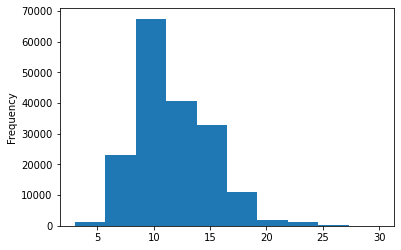

In [24]:
# Lets check the length of different lines
train_df.total_lines.plot.hist();

## Get lists of sentences

In [25]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [26]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [27]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse = False) # we want non-sparse matrix

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

### Label encode labels

In [28]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [29]:
# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [30]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Experiments we're running
|Experiment|Model|
|----------|-----|
|0|Naive Bayes with TF-IDF encoder (baseline)|
|1|Conv1D with token embeddings|
|2|TensorFlow Pretrained Feature Extractor|
|3|Conv1D with character embeddings|
|4|Pretrained token embeddings (same as 2) + character embeddings (same as 3)|
|5|Pretrained token embeddings + character embeddings + positional embeddings|

## Starting with a series of modelling experiments...

As usual we're going to be trying out a bunch of different models and seeing which one works best.

And as always, we're going to start with a baseline (TF-IDF Multinomial Naive Bayes classifier)

## Model 0: Naive Bayes with TF-IDF encoder 

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

model_0 = Pipeline(
    [
        ('tf_idf_vectorizer', TfidfVectorizer()),
        ('classifier_layer', MultinomialNB())
    ]
)

model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tf_idf_vectorizer', TfidfVectorizer()),
                ('classifier_layer', MultinomialNB())])

In [32]:
model_0_preds = model_0.predict(val_sentences)
baseline_results = calculate_results(val_labels_encoded, model_0_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [33]:
from helper_functions import make_confusion_matrix

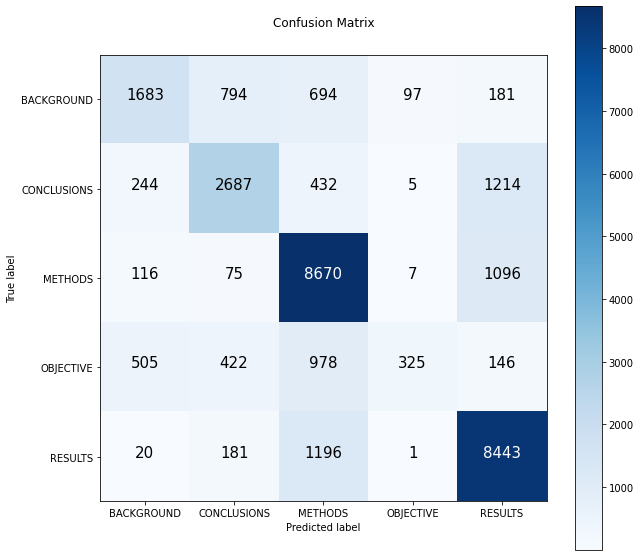

In [34]:
make_confusion_matrix(val_labels_encoded, model_0_preds, classes = list(class_names))

## Model 1: Conv1D with token embeddings

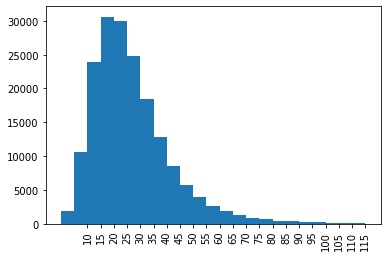

In [35]:
plt.hist([len(sentence.split()) for sentence in train_sentences], bins = np.arange(0, 120, 5));
plt.xticks(np.arange(10, 120, 5), rotation = 90);
# plt.axvline(110, color = "black");
plt.show();

In [36]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile([len(sentence.split()) for sentence in train_sentences], 95))
output_seq_len

55

In [37]:
# Maximum sequence length in the training set
max([len(sentence.split()) for sentence in train_sentences])

296

We want to make a layer which maps our texts from words to numbers. We need to answer how many words are in our vocab? (taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf)

In [38]:
MAX_TOKENS = 68000
SEQUENCE_LENGTH = 55

text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens = MAX_TOKENS,
    output_sequence_length = SEQUENCE_LENGTH,
    output_mode = "int",
    name = "text_vectorizer_layer"
)

text_vectorizer.adapt(train_sentences)

In [39]:
import random

target_sentence = random.choice(train_sentences)
print(f'Text:\n{target_sentence}')
print(f'\nLength of text: {len(target_sentence.split())}')
print(f'\nVectorized text: {text_vectorizer(target_sentence)}')

Text:
from january @ to january @ , @ consecutive patients with single and primary ureteral stones were prospectively enrolled .

Length of text: 20

Vectorized text: [  27 1174    6 1174  753   12    7  312    3   56 5783 3005    9 1125
  230    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [41]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(rct_20k_text_vocab)}')
print(f'Most common words in vocab: {rct_20k_text_vocab[:5]}')
print(f'Least common words in vocab: {rct_20k_text_vocab[-5:]}')

Number of words in vocab: 64841
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [42]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorizer_layer',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Create a Text Embedding

In [43]:
embedding = tf.keras.layers.Embedding(input_dim = len(text_vectorizer.get_vocabulary()),
                                      output_dim = 128,
                                      input_length = SEQUENCE_LENGTH,
                                      mask_zero = True,
                                      name = "embedding")
embedding(text_vectorizer([target_sentence]))

<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[-0.0167716 ,  0.04630451,  0.01582749, ...,  0.02546895,
          0.03446201,  0.00017165],
        [ 0.04612538, -0.04550108,  0.01582387, ...,  0.01159892,
         -0.03450843,  0.04852108],
        [-0.00020263, -0.02718488, -0.02364438, ...,  0.03082055,
         -0.03343347, -0.02800615],
        ...,
        [ 0.04973415, -0.00771631,  0.00915462, ..., -0.04938524,
         -0.02703495,  0.02985864],
        [ 0.04973415, -0.00771631,  0.00915462, ..., -0.04938524,
         -0.02703495,  0.02985864],
        [ 0.04973415, -0.00771631,  0.00915462, ..., -0.04938524,
         -0.02703495,  0.02985864]]], dtype=float32)>

### Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed at length in these two resources:

* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [44]:
# Turn our data into TensorFlow Datasets

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [45]:
# Take the TensorSliceDataset's and turn it into prefetched datasets

BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [46]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Building, Compiling and Fitting the model

In [47]:
SAVE_DIR = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/TensorBoard/SkimLit"

In [48]:
# Build the model
model_1 = tf.keras.Sequential(
    [
        text_vectorizer,
        embedding,
        tf.keras.layers.Conv1D(64, kernel_size = 5, activation = "relu", name = "conv1d_layer"),
        tf.keras.layers.GlobalMaxPooling1D(name = "pooling_layer"),
        tf.keras.layers.Dense(num_classes, activation = "softmax", name = "output_layer")
    ], name = "model_1_conv1d"
)

# Compile the model
model_1.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
history_model_1 = model_1.fit(
    train_dataset,
    epochs = 3, # set to 3 for faster training
    steps_per_epoch = int(0.1*len(train_dataset)), # to rapidly prototype, set to int(0.1 * len(train_dataset))
    validation_data = valid_dataset,
    validation_steps = int(0.1 * len(valid_dataset)), # to rapidly prototype, set to int(0.1 * len(valid_dataset))
    callbacks = [create_tensorboard_callback(SAVE_DIR, "model_1_conv1d")]
)

Saving TensorBoard log files to: /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/TensorBoard/SkimLit/model_1_conv1d/20220719-041706
Epoch 1/3
562/562 [==============================] - 18s 12ms/step - loss: 0.8424 - accuracy: 0.6816 - val_loss: 0.6031 - val_accuracy: 0.7759
Epoch 2/3
562/562 [==============================] - 6s 10ms/step - loss: 0.5843 - accuracy: 0.7846 - val_loss: 0.5531 - val_accuracy: 0.7945
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.5525 - accuracy: 0.7977 - val_loss: 0.5291 - val_accuracy: 0.8045


In [49]:
model_1_preds = tf.squeeze(tf.argmax(model_1.predict(valid_dataset), axis = 1))

In [51]:
val_labels = []
for _, labels in valid_dataset.unbatch():
    val_labels.append(labels)

model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results

{'accuracy': 80.52760492519528,
 'f1': 0.8040228749000933,
 'precision': 0.8043001371386198,
 'recall': 0.8052760492519528}

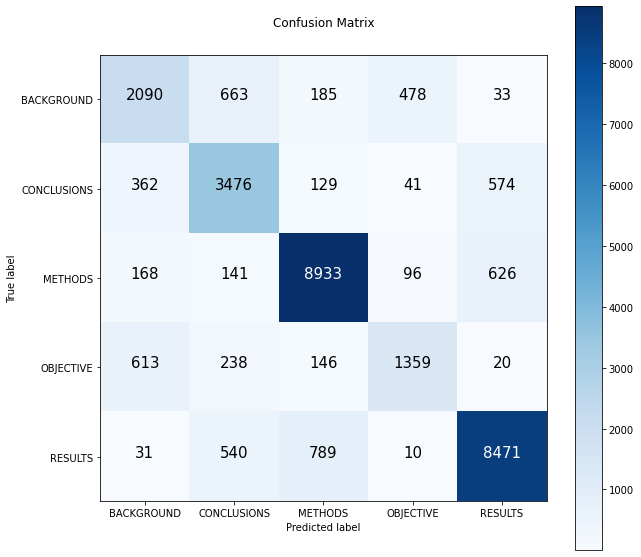

In [53]:
make_confusion_matrix(tf.argmax(val_labels, axis = 1), model_1_preds, classes = list(class_names))

## Model 2: TensorFlow Pretrained Feature Extractor

The paper uses GloVe embeddings. However, we're going to stick with the USE pre-trained embeddings we used earlier

In [54]:
import tensorflow_hub as hub
feature_extractor = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable = False,
    input_shape = [],
    dtype = tf.string,
    name = "USE"
)

model_2 = tf.keras.Sequential(
    [
        feature_extractor,
        tf.keras.layers.Dense(128, activation = "relu", name = "hidden_layer_dense"),
        tf.keras.layers.Dense(num_classes, activation = "softmax", name = "output_layer")
    ], name = "model_2"
)

model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 hidden_layer_dense (Dense)  (None, 128)               65664     
                                                                 
 output_layer (Dense)        (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [55]:
# Compile the model
model_2.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
history_model_2 = model_2.fit(
    train_dataset,
    epochs = 3,
    steps_per_epoch = int(0.1 * len(train_dataset)),
    validation_data = valid_dataset,
    validation_steps = int(0.1 * len(valid_dataset)),
    callbacks = [create_tensorboard_callback(SAVE_DIR, "model_2_USE")]
)

Saving TensorBoard log files to: /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/TensorBoard/SkimLit/model_2_USE/20220719-042026
Epoch 1/3
562/562 [==============================] - 10s 13ms/step - loss: 0.9167 - accuracy: 0.6486 - val_loss: 0.7973 - val_accuracy: 0.6885
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7695 - accuracy: 0.7005 - val_loss: 0.7557 - val_accuracy: 0.7048
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7524 - accuracy: 0.7129 - val_loss: 0.7396 - val_accuracy: 0.7111


In [56]:
model_2_preds = tf.squeeze(tf.argmax(model_2.predict(valid_dataset), axis = 1))

In [58]:
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

{'accuracy': 71.31603336422614,
 'f1': 0.709812383043778,
 'precision': 0.7133953842911782,
 'recall': 0.7131603336422614}

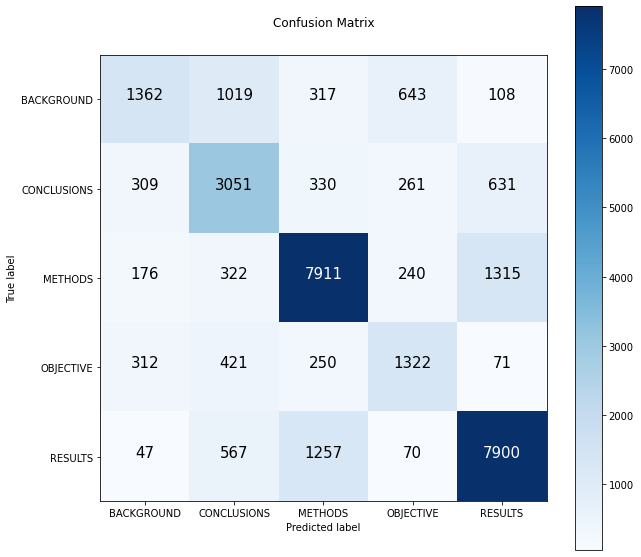

In [59]:
make_confusion_matrix(tf.argmax(val_labels, axis = 1), model_2_preds, classes = list(class_names))

## Model 3: Conv1D with character embeddings

The paper which we're replicating states that they used a combination of token and character level embeddings.

Previously we've taken token level embeddings. Now we'll do similar steps for character level embeddings

### Creating a character-level tokenizer

In [60]:
# Make function to split sentences into characters

def split_chars(text):
    """
    """
    temp = list(text)
    return " ".join(temp)

In [61]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [62]:
# Whats the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

In [63]:
output_seq_char_len = np.percentile(char_lens, 95)
output_seq_char_len

290.0

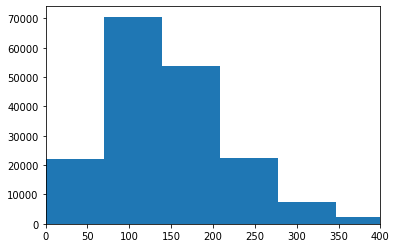

In [64]:
plt.hist(char_lens, bins = 20);
plt.xlim(0, 400);

In [65]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [66]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV
char_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens = NUM_CHAR_TOKENS,
    # standardize = None, # set standardization to None if you want to retain punctuations.
    output_sequence_length = int(output_seq_char_len),
    name = "char_vectorizer"
)

In [67]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [68]:
# Without standardization
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in character vocab: {len(char_vocab)}')
print(f'5 most common characters in character vocab: {char_vocab[:5]}')
print(f'5 least common characters in character vocab: {char_vocab[-5:]}')

Number of different characters in character vocab: 28
5 most common characters in character vocab: ['', '[UNK]', 'e', 't', 'i']
5 least common characters in character vocab: ['k', 'x', 'z', 'q', 'j']


In [69]:
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in character vocab: {len(char_vocab)}')
print(f'5 most common characters in character vocab: {char_vocab[:5]}')
print(f'5 least common characters in character vocab: {char_vocab[-5:]}')

Number of different characters in character vocab: 28
5 most common characters in character vocab: ['', '[UNK]', 'e', 't', 'i']
5 least common characters in character vocab: ['k', 'x', 'z', 'q', 'j']


In [70]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f'Charified text:\n{random_train_chars}')
print(f'Length of random_train_chars: {len(random_train_chars)}')
vectorized_chars = char_vectorizer([random_train_chars])
print(f'\nVectorized chars:\n{vectorized_chars}')
print(f'\nLength of Vectorized chars:{len(vectorized_chars[0])}')

Charified text:
n o   d i r e c t   e f f e c t   o f   i p s   o n   m e n t a l   h e a l t h   ,   s e l f - e s t e e m   o r   q u a l i t y   o f   l i f e   w a s   f o u n d   .
Length of random_train_chars: 169

Vectorized chars:
[[ 6  7 10  4  8  2 11  3  2 17 17  2 11  3  7 17  4 14  9  7  6 15  2  6
   3  5 12 13  2  5 12  3 13  9  2 12 17  2  9  3  2  2 15  7  8 26 16  5
  12  4  3 19  7 17 12  4 17  2 20  5  9 17  7 16  6 10  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  

In [71]:
char_embedding = tf.keras.layers.Embedding(
    input_dim = len(char_vocab),
    input_length = output_seq_char_len,
    output_dim = 25, # this is the size of the char embedding in the paper
    name = "char_embed"
)

In [72]:
# Test our character embedding layer
print(f'Charified text:\n{random_train_chars}\n')
char_embed_example = char_embedding(char_vectorizer([random_train_chars]))
print(f'Embedded chars (after vectorization and embedding):\n{char_embed_example}\n')
print(f'Character embedding shape: {char_embed_example.shape}')

Charified text:
n o   d i r e c t   e f f e c t   o f   i p s   o n   m e n t a l   h e a l t h   ,   s e l f - e s t e e m   o r   q u a l i t y   o f   l i f e   w a s   f o u n d   .

Embedded chars (after vectorization and embedding):
[[[-0.0037883  -0.02075478  0.02221242 ...  0.03466335 -0.03839608
   -0.04776203]
  [ 0.00184017 -0.01951023  0.04267582 ... -0.03027594  0.00153964
    0.035516  ]
  [ 0.01782416 -0.03834609 -0.03435724 ...  0.00603895  0.03541248
    0.0417575 ]
  ...
  [ 0.0310578   0.02995372  0.04975996 ...  0.04665753 -0.00928641
    0.00240265]
  [ 0.0310578   0.02995372  0.04975996 ...  0.04665753 -0.00928641
    0.00240265]
  [ 0.0310578   0.02995372  0.04975996 ...  0.04665753 -0.00928641
    0.00240265]]]

Character embedding shape: (1, 290, 25)


### Building Conv1D model

In [73]:
inputs = tf.keras.layers.Input(shape = (1,), dtype = "string", name = "input_layer")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embedding(char_vectors)
x = tf.keras.layers.Conv1D(64, kernel_size = 5, padding = "same", activation = "relu", name = "conv1d_layer")(char_embeddings)
x = tf.keras.layers.GlobalMaxPool1D(name = "max_pool_layer")(x)
outputs = tf.keras.layers.Dense(num_classes, activation = "softmax", name = "output_layer")(x)
model_3 = tf.keras.Model(inputs, outputs, name = "model_3_char_level_conv1d")

# Compile the model
model_3.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

model_3.summary()

Model: "model_3_char_level_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_layer (Conv1D)       (None, 290, 64)           8064      
                                                                 
 max_pool_layer (GlobalMaxPo  (None, 64)               0         
 oling1D)                                                        
                                                                 
 output_layer (Dense)        (None, 5)   

In [74]:
train_chars_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_chars_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_chars_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [75]:
# Fit the model
history_model_3 = model_3.fit(
    train_chars_dataset,
    epochs = 3,
    steps_per_epoch = int(0.1 * len(train_chars_dataset)),
    validation_data = val_chars_dataset,
    validation_steps = int(0.1 * len(val_chars_dataset)),
    callbacks = [create_tensorboard_callback(SAVE_DIR, "model_3_Conv1D_char")]
)

Saving TensorBoard log files to: /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/TensorBoard/SkimLit/model_3_Conv1D_char/20220719-042507
Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2616 - accuracy: 0.4892 - val_loss: 1.0477 - val_accuracy: 0.5871
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0155 - accuracy: 0.5911 - val_loss: 0.9428 - val_accuracy: 0.6210
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.9319 - accuracy: 0.6341 - val_loss: 0.8714 - val_accuracy: 0.6622


In [76]:
model_3_preds = tf.squeeze(tf.argmax(model_3.predict(val_chars_dataset), axis = 1))

In [78]:
model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results

{'accuracy': 65.39785515689131,
 'f1': 0.6444795862146715,
 'precision': 0.6494008676796289,
 'recall': 0.653978551568913}

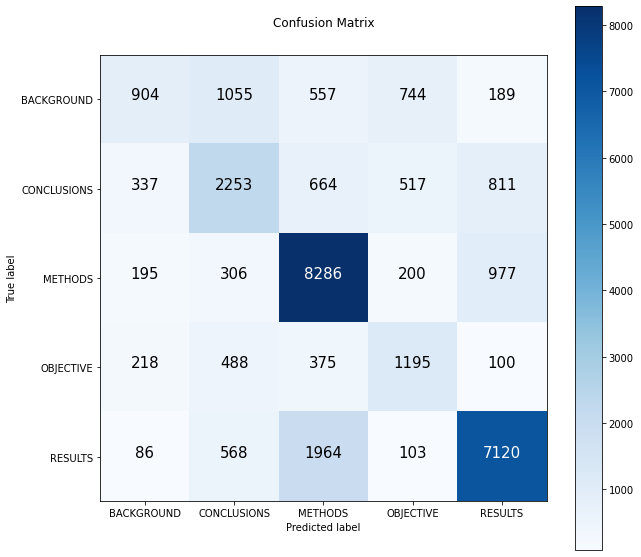

In [79]:
make_confusion_matrix(tf.argmax(val_labels, axis = 1), model_3_preds, classes = list(class_names))

## Model 4: Combining Pretrained Token + Character Level Embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar to `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 and 2 with a concatenation (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [80]:
# 1. Setup token inputs/model
token_inputs = tf.keras.layers.Input(shape = [], dtype = tf.string, name = "token_input")
token_embeddings = feature_extractor(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation = "relu", name = "token_outputs")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs, outputs = token_outputs)

# 2. Setup char inputs/model
char_inputs = tf.keras.layers.Input(shape = (1,), dtype = tf.string, name = "char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs = char_inputs, outputs = char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = tf.keras.layers.Concatenate(name = "token_char_hybrid")([token_model.output, char_model.output])

# 4. Create output layers -adding in Dropout, discussed
combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = tf.keras.layers.Dense(128, activation = "relu")(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)
output_layer = tf.keras.layers.Dense(num_classes, activation = "softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input], outputs = output_layer, name = "model_4_token_and_char_embeddings")

In [81]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   [

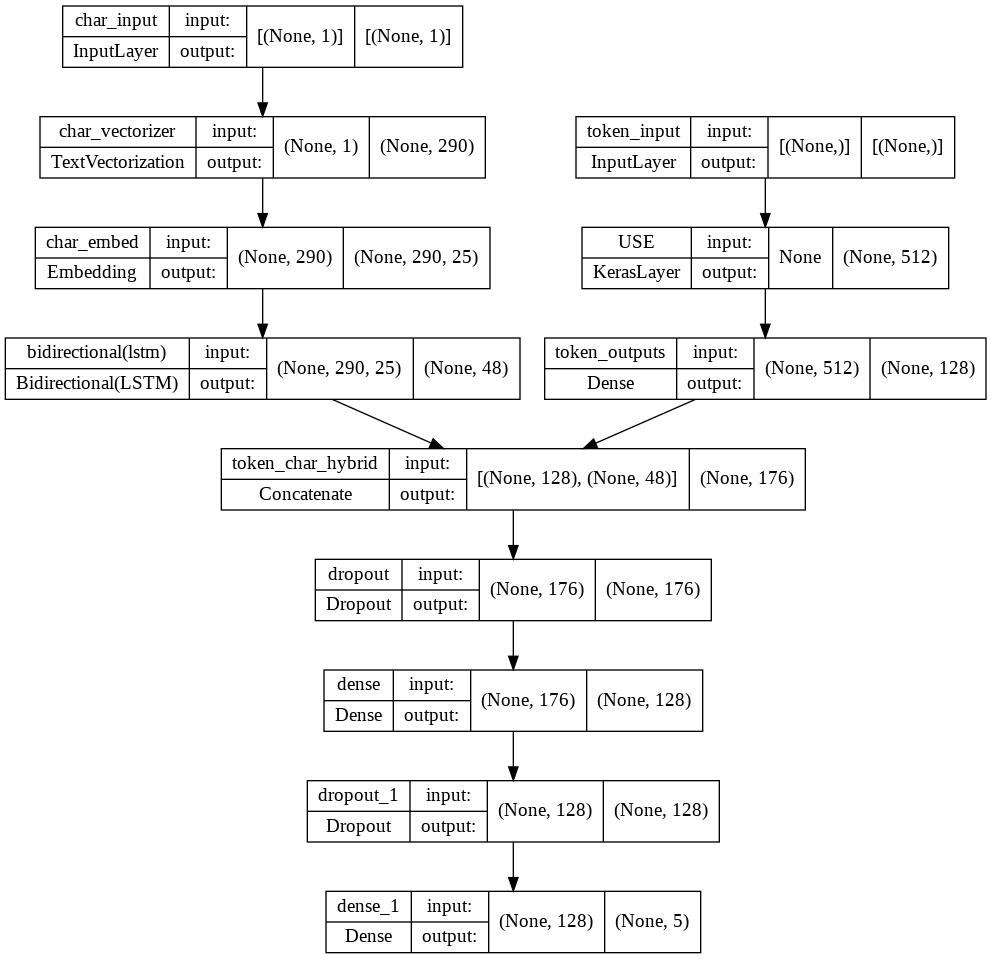

In [83]:
from tensorflow.keras.utils import plot_model

plot_model(model_4, show_shapes = True)

In [84]:
# Compile token char model
model_4.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

### Combining token and character data into a tf.data Dataset

In [85]:
def construct_dataset(token_sequence, char_sequence, label_data, batch_size = 32):
    data = tf.data.Dataset.from_tensor_slices((token_sequence, char_sequence))
    labels = tf.data.Dataset.from_tensor_slices(label_data)
    dataset = tf.data.Dataset.zip((data, labels))
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [86]:
# train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) #make data
# train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) #make labels

# train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# # Prefetch and batch train_data
# train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_char_token_dataset = construct_dataset(train_sentences, train_chars, train_labels_one_hot)

In [87]:
val_char_token_dataset = construct_dataset(val_sentences, val_chars, val_labels_one_hot)
test_char_token_dataset = construct_dataset(test_sentences, test_chars, test_labels_one_hot)

In [88]:
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [89]:
# Fit the model
history_model_4 = model_4.fit(
    train_char_token_dataset,
    epochs = 3,
    steps_per_epoch = int(0.1 * len(train_char_token_dataset)),
    validation_data = val_char_token_dataset,
    validation_steps = int(0.1 * len(val_char_token_dataset)),
    callbacks = [create_tensorboard_callback(SAVE_DIR, "char_token_model_4")]
)

Saving TensorBoard log files to: /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/TensorBoard/SkimLit/char_token_model_4/20220719-043024
Epoch 1/3
562/562 [==============================] - 27s 40ms/step - loss: 0.9867 - accuracy: 0.6033 - val_loss: 0.7881 - val_accuracy: 0.6955
Epoch 2/3
562/562 [==============================] - 20s 35ms/step - loss: 0.8053 - accuracy: 0.6898 - val_loss: 0.7177 - val_accuracy: 0.7324
Epoch 3/3
562/562 [==============================] - 20s 35ms/step - loss: 0.7768 - accuracy: 0.7000 - val_loss: 0.6894 - val_accuracy: 0.7390


In [90]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.6958 - accuracy: 0.7345


[0.6958367824554443, 0.7345094680786133]

In [91]:
# Make predictions using the token-charater model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_preds = tf.squeeze(tf.argmax(model_4_pred_probs, axis = 1))
model_4_results = calculate_results(val_labels_encoded, model_4_preds)
model_4_results

{'accuracy': 73.45094664371773,
 'f1': 0.7319996225462605,
 'precision': 0.7346476009225987,
 'recall': 0.7345094664371773}

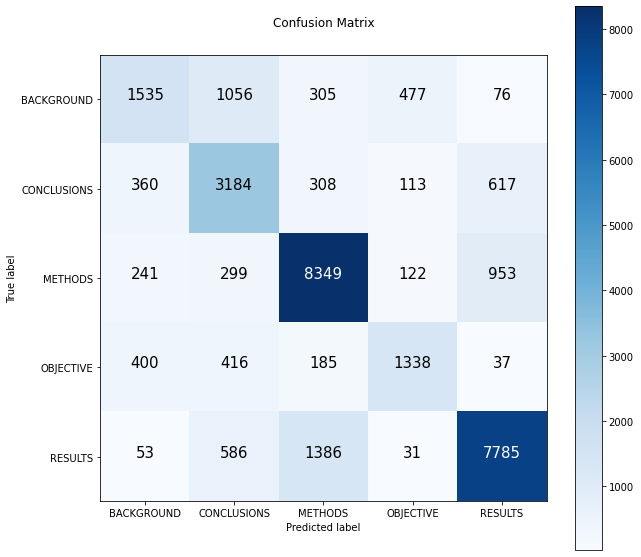

In [92]:
make_confusion_matrix(val_labels_encoded, model_4_preds, classes = list(class_names))

In [93]:
model_1_results

{'accuracy': 80.52760492519528,
 'f1': 0.8040228749000933,
 'precision': 0.8043001371386198,
 'recall': 0.8052760492519528}

## Feature Engineering

Taking non-obvious features from the data and encoding them numerically to help our model learn

How can we add extra sources of data to our model?

## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [94]:
train_df.head()

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11


Any engineered features used to train a model need to be available at test time. In our time the line numbers and total lines are available

### Create positional embeddings